In [1]:
import pandas as pd
from river import stream,tree,metrics
import utils
from encoding import prefix_bin
import csv
import copy, json
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
import pickle as pkl
import matplotlib.pyplot as plt
import os

In [2]:
dataset = stream.iter_csv(
            './bpic17_sampling.csv',
            )

totallength = len(list(dataset))

In [3]:
dataset = stream.iter_csv(
            './bpic17_sampling.csv',
#             drop=['Complete Timestamp'],
            )
enctype = 'Index-base'

In [4]:
print(next(dataset))

({'Case ID': 'Application_1003639640', 'Activity': 'A_Create Application', 'Resource': 'User_10', 'Complete Timestamp': '2016-01-26 12:31:07.592', 'progress': ''}, None)


In [5]:
key_pair = {
'Case ID':'caseid',
'Activity':'activity',
'Resource':'resource',
'Complete Timestamp':'ts',
}
catatars= ['activity','resource']

case_dict ={}
training_models ={}
feature_matrix ={}

casecount = 0
rowcounter = 0
resultdict ={}
acc_dict ={}
window_acc_dict={}
running_case = 0
prediction_result = {}
graceperiod_finish=0
finishedcases = set()
usedingrace = set()
window_size = 50

window_label_dist ={}

In [7]:
for x,y in dataset:
    if rowcounter%500 == 0:
        print(round(rowcounter*100/totallength,2) ,'%', 'Case finished: %s'%(casecount))
    rowcounter +=1
    utils.dictkey_chg(x, key_pair)
    # Event stream change dictionary keys
    x['ts'] = x['ts'][:-4]
    
    # Check label possible
    
    # Initialize case by prefix length
    caseid = x['caseid']    
    progress = x['progress']

    x.pop('progress')
    x.pop('caseid')
    case_bin = prefix_bin(caseid, x)
    if caseid not in list(case_dict.keys()):
        case_bin.set_prefix_length(1)    
        case_dict[caseid] = []
    elif caseid in finishedcases:
        pass
    else:
        case_bin.set_prefix_length(len(case_dict[caseid])+1)
        case_bin.set_prev_enc(case_dict[caseid][-1])
    
    # Encode event and cases and add to DB

#     case_bin.set_enctype(enctype)
    case_bin.update_encoded(catattrs=catatars,enctype=enctype)
    next_activity = [x for x in case_bin.encoded.keys() if 'activity_%s'%(case_bin.prefix_length) in x].pop()
    
    if case_bin.prefix_length != 1:
        case_bin.prev_enc.update_truelabel(next_activity)

    ts = case_bin.event['ts']
    case_dict[caseid].append(case_bin)
    usedingrace.add(caseid)
    # Detect label appeared case 
    if progress != '' and caseid not in finishedcases:
        finishedcases.add(caseid)
        # Adding newly finished case to training set.    
        casecount +=1
        # Grace period to collect feature matrix
        if casecount <200:
            case_length = len(case_dict[caseid])
            for prefix in range(1, case_length):
                if 'prefix_%s'%(prefix+1) not in list(feature_matrix.keys()):
                    feature_matrix['prefix_%s'%(prefix+1)]=set()
                    # Initialize classifier and performance matrix and updating count
                    training_models['prefix_%s'%(prefix+1)] = [tree.ExtremelyFastDecisionTreeClassifier(grace_period=100,split_criterion='info_gain'),
                                                               metrics.Accuracy(),
                                                               0,0]
                feature_list = list(case_dict[caseid][prefix].encoded.keys())
                for x in feature_list: feature_matrix['prefix_%s'%(prefix+1)].add(x) 
            graceperiod_finish = case_dict[caseid][-1].event['ts']
            for t in training_models.keys():
                training_models[t][3] = graceperiod_finish
            case_dict.pop(caseid)            
        else:
            break

IndexError: list index out of range

In [15]:
print(case_dict['Application_1257947863'][0].__dict__)

{'prefix_length': 1, 'caseid': 'Application_1257947863', 'event': {'activity': 'A_Create Application', 'resource': 'User_25', 'ts': datetime.datetime(2016, 1, 13, 12, 8, 4)}, 'enctype': 'Index-base', 'start_ts': datetime.datetime(2016, 1, 13, 12, 8, 4), 'prev_enc': None, 'encoded': {'duration_1': 0, 'cumduration_1': 0, 'activity_1 A_Create Application': 1, 'resource_1 User_25': 1}, 'predicted': {}, 'true_label': None, 'grace_updated': False}


In [24]:
maximum_prefix = sorted([int(x.split('_')[1]) for x in training_models.keys()])[-1]
print(maximum_prefix)
print(training_models.keys())
# maximum_prefix = 15

91
dict_keys(['prefix_2', 'prefix_3', 'prefix_4', 'prefix_5', 'prefix_6', 'prefix_7', 'prefix_8', 'prefix_9', 'prefix_10', 'prefix_11', 'prefix_12', 'prefix_13', 'prefix_14', 'prefix_15', 'prefix_16', 'prefix_17', 'prefix_18', 'prefix_19', 'prefix_20', 'prefix_21', 'prefix_22', 'prefix_23', 'prefix_24', 'prefix_25', 'prefix_26', 'prefix_27', 'prefix_28', 'prefix_29', 'prefix_30', 'prefix_31', 'prefix_32', 'prefix_33', 'prefix_34', 'prefix_35', 'prefix_36', 'prefix_37', 'prefix_38', 'prefix_39', 'prefix_40', 'prefix_41', 'prefix_42', 'prefix_43', 'prefix_44', 'prefix_45', 'prefix_46', 'prefix_47', 'prefix_48', 'prefix_49', 'prefix_50', 'prefix_51', 'prefix_52', 'prefix_53', 'prefix_54', 'prefix_55', 'prefix_56', 'prefix_57', 'prefix_58', 'prefix_59', 'prefix_60', 'prefix_61', 'prefix_62', 'prefix_63', 'prefix_64', 'prefix_65', 'prefix_66', 'prefix_67', 'prefix_68', 'prefix_69', 'prefix_70', 'prefix_71', 'prefix_72', 'prefix_73', 'prefix_74', 'prefix_75', 'prefix_76', 'prefix_77', 'prefi

In [26]:
case_dict ={}
for x,y in dataset:
    if rowcounter%3000 == 0:
        print(round(rowcounter*100/totallength,2) ,'%', 'Case finished: %s'%(casecount), 'Running case: %s'%(running_case))
    rowcounter +=1
    # Event stream change dictionary keys
    utils.dictkey_chg(x, key_pair)

    x['ts'] = x['ts'][:-4]
#     x['ts'] += ' 00:00:00' 

    # Check label possible
 

    # Initialize case by prefix length
    
        # Initialize case by prefix length
    caseid = x['caseid']    
    progress = x['progress']

    x.pop('progress')
    x.pop('caseid')
    
    if caseid not in usedingrace:
        case_bin = prefix_bin(caseid, x)
        case_bin.set_enctype(enctype)

        if caseid not in list(case_dict.keys()):
            case_bin.set_prefix_length(1)    
            case_dict[caseid] = []
            running_case +=1
        elif caseid in finishedcases:
            pass
        else:
            case_bin.set_prefix_length(len(case_dict[caseid])+1)
            case_bin.set_prev_enc(case_dict[caseid][-1])

        # Encode event and cases and add to DB
        case_bin.update_encoded(catattrs=catatars,enctype=enctype)        
        next_activity = [x for x in case_bin.encoded.keys() if 'activity_%s'%(case_bin.prefix_length) in x].pop()

        if case_bin.prefix_length >= 2:
            case_bin.prev_enc.update_truelabel(next_activity)

        ts = case_bin.event['ts']
        if case_bin.prefix_length >=2:
            case_bin.encoded = utils.readjustment_training(case_bin.encoded, feature_matrix['prefix_%s'%(case_bin.prefix_length)])
            x_test = case_bin.encoded
            model = training_models['prefix_%s'%(case_bin.prefix_length)][0]
            y_pred = model.predict_one(x_test)
            if type(y_pred) != str:
                y_pred = 'False'
            modelid,pred_value = copy.deepcopy(training_models['prefix_%s'%(case_bin.prefix_length)][2]), copy.deepcopy(y_pred)
            case_bin.update_prediction((modelid, (pred_value,ts)))        
        case_dict[caseid].append(case_bin)

        # Detect label appeared case 
        if progress != '' and caseid not in finishedcases:
            finishedcases.add(caseid)
            # Adding newly finished case to training set.    
            casecount +=1    
            # Real training start

            # Modify encoded attributes of cases with feature matrix
            case_length = len(case_dict[caseid])
            
            y = next_activity
            x = case_dict[caseid][-2].encoded
            previous_event_length = case_dict[caseid][-2].prefix_length
            model = training_models['prefix_%s'%(previous_event_length)][0]
            model.learn_one(x,y)
            training_models['prefix_%s'%(previous_event_length)][2] +=1
            y_pred = model.predict_one(x)
            training_models['prefix_%s'%(previous_event_length)][1].update(y,y_pred)

            for cases in list(case_dict.keys()):
                if len(case_dict[cases]) == previous_event_length-1:
                    x_test = case_dict[cases][-1].encoded
                    y_pred = model.predict_one(x_test)
                    modelid,pred_value = copy.deepcopy(training_models['prefix_%s'%(prefix+1)][2]), copy.deepcopy(y_pred)
                    case_dict[cases][-1].update_prediction((modelid, (pred_value,ts)))
                    prediction_key = str(cases)+'_'+str(prefix+1)
                    if str(cases)+'_'+str(prefix+2) not in prediction_result.keys():
                        if prediction_key not in prediction_result.keys():
                            prediction_result[prediction_key] = {}
                            prediction_result[prediction_key][modelid] = (pred_value,ts)
                        else:
                            prediction_result[prediction_key][modelid] = (pred_value,ts)
#             print(case_dict[caseid][-2].predicted)
            copying = copy.deepcopy(case_dict[caseid])
            resultdict[caseid] = copying
            case_dict[caseid] =[]
            running_case -=1

            for prefix in training_models.keys():
                if prefix not in list(acc_dict.keys()):
                    acc_dict[prefix]=[training_models[prefix][1].get()]
                else:
                    acc_dict[prefix].append(training_models[prefix][1].get())


15.11 % Case finished: 232 Running case: 1


KeyError: 'prefix_92'

In [119]:
# Continuous evaluation performance by prefix length-case bin 

y_true, target_pred = utils.pl_case_continuous_evaluation(resultdict)
bin_event_acc = {}
max_length = max([len(x) for x in resultdict])

for prefix in tqdm(list(y_true.keys())):
    t = int(prefix.split('_')[-1])
    if t in range(2,maximum_prefix):
        if '%s'%(t) not in list(bin_event_acc.keys()):
            bin_event_acc['%s'%(t)] ={'y_true':[],'y_pred':[]}
        else:
            bin_event_acc['%s'%(t)]['y_true'].append(y_true[prefix])
            bin_event_acc['%s'%(t)]['y_pred'].append(target_pred[prefix])
for prefix in bin_event_acc.keys():
#     print(prefix)
#     print(classification_report(bin_event_acc[prefix]['y_true'], bin_event_acc[prefix]['y_pred']))
    bin_event_acc[prefix]= accuracy_score(bin_event_acc[prefix]['y_true'], bin_event_acc[prefix]['y_pred'])

0it [00:00, ?it/s]


Text(0.5, 0, 'Prefix length')

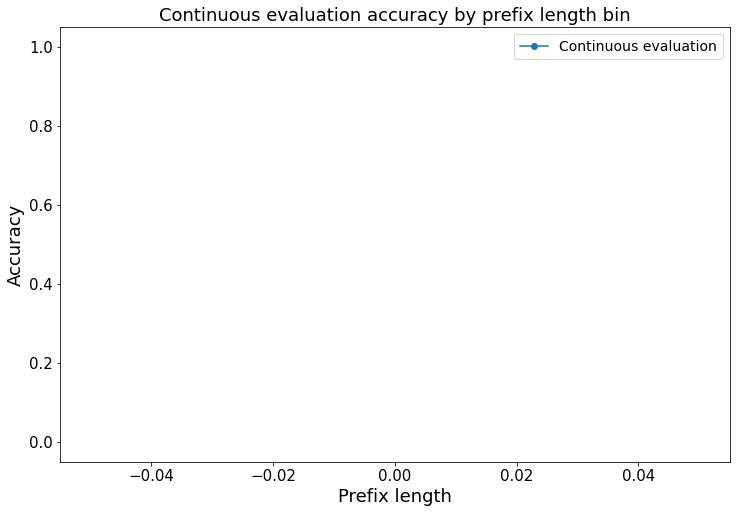

In [120]:
plt.figure(figsize=(12, 8))

plt.rc('axes', titlesize=18) # fontsize of the axes title 
plt.rc('axes', labelsize=18) # fontsize of the x and y labels 
plt.rc('xtick', labelsize=15) # fontsize of the tick labels 
plt.rc('ytick', labelsize=15) # fontsize of the tick labels 
plt.rc('legend', fontsize=14) # legend fontsize 

axes = plt.gca()
axes.set_ylim([-0.05, 1.05])

x,ce_acc_y = list(bin_event_acc.keys()),[bin_event_acc[x] for x in bin_event_acc.keys()]
plt.plot(x,ce_acc_y,'-o',label='Continuous evaluation')
# plt.plot(x,last_acc_y, '-o',label = 'Last accuracy')

# y_gap = [[t, last_acc_y[pos]] if t<= last_acc_y[pos] else (last_acc_y[pos], t) for pos,t in enumerate(ce_acc_y)]
# for pos in range(len(y_gap)):
#     if y_gap[pos][0] ==0:
#         y_gap[pos][0] = 0.05
#     if y_gap[pos][1] ==0:
#         y_gap[pos][1] = 0.05
plt.title('Continuous evaluation accuracy by prefix length bin')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Prefix length')
    

# plt.savefig('./img/%s continuous acc.png'%(classifier))

# print(dataset_label)
# with open('./result/%s/%s_continuous_evaluation_plbin.pkl'%(dataset_label,classifier),'wb') as f:
#     pkl.dump([x,ce_acc_y],f)